# Table of contents

1. [Get data](#Get-data)
2. [Check data](#Check-data)
3. [Load data](#Load-data)
4. [Preprocess](#Preprocess)
5. [Remove outliers](#Remove-outliers)
6. [Aggregate data and add proxy variable](#Aggregate-data)
7. [Event frequency](#Event-frequency)
8. [Correlation plot](#Correlation-plot)
9. [Cross-correlation](#Cross-correlation)
10. [Time-series plot](#Time-series-plot)
11. [Seasonal pattern based on Event](#Seasonal-pattern-based-on-Event)
12. [Diurnal pattern based on Event](#Diurnal-pattern-based-on-Event)
13. [Check normality assumptions of all parameters for each Event category](#Check-normality-assumptions-of-all-parameters-for-each-Event-category)
14. [Kruskal-Wallis test](#Kruskal-Wallis-test)
15. [PCA](#PCA)
16. [K-nearest neighbor](#K-nearest-neighbor)


# Import os library to run get data part

In [1]:
import os

# Get data
<div class="alert alert-block alert-danger"> <b> I created some scripts to get data from the server and parse them correctly. They will be downloaded into your machine, so you don't need to run these chunk again in the future.</b> This is just to make sure that we are analyzing on the same data and tutor can check them easily 

Check current working directory, make sure this directory is where you want to work in. I will create a subdirectory called "data" and download all csv files in there

In [2]:
os.getcwd()

'C:\\Users\\VIET\\Desktop\\Python\\NPF-smearII'

Download all data and put in a subdirectory called 'data'. A success run will return value 0

In [3]:
os.system('python download_data.py') # exploit multi-threading for IO

0

Combine all data in to a new csv file called fulldata.csv. A success run will return value 0

In [4]:
os.system('python parse_data.py') # exploit multi-processing CPU to parse each file on each CPU

0

******

<div class="alert alert-block alert-success"> <b>START FROM HERE IF YOU ALREADY HAVE THE DATA <b>

# Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns

# Load data

In [2]:
df_raw = pd.read_csv('fulldata.csv', parse_dates = ['Time'])
df_raw.columns = [x if x == "Time" else x[9:] for x in df_raw.columns] # Remove unnecessary part in column names

In [3]:
event = pd.read_csv('Event_classification_2004-2014.csv')
event['Time'] = pd.to_datetime(event.Date, format = "%d-%b-%Y")
event.drop('Date', axis = 1, inplace = True)

condense_raw = pd.read_csv('CS_2004_2014.csv')
condense_raw['Time'] = pd.to_datetime(condense_raw.times, format = "%d-%b-%Y %H:%M:%S")
condense_raw.drop('times', axis = 1, inplace = True)
condense_raw.rename(columns = {'Condensation_sink': 'CS_sink'}, inplace = True)

In [4]:
condense_raw

,CS_sink,Time
0,0.002163,2004-01-01 00:08:41
1,0.003151,2004-01-01 00:18:40
2,0.002770,2004-01-01 00:28:41
3,0.001783,2004-01-01 00:38:40
4,0.001543,2004-01-01 00:48:40
...,...,...
568294,0.002030,2014-12-31 23:10:01
568295,0.002027,2014-12-31 23:20:00
568296,0.001903,2014-12-31 23:30:01
568297,0.001925,2014-12-31 23:40:00


### Get 2008 & 2009

In [5]:
condense_raw = condense_raw[(condense_raw.Time >= pd.Timestamp(2008,1,1)) & (condense_raw.Time < pd.Timestamp(2010,1,1))]
event = event[(event.Time >= pd.Timestamp(2008,1,1)) & (event.Time < pd.Timestamp(2010,1,1))]
condense_raw.reset_index(drop = True, inplace = True)
event.reset_index(drop = True, inplace = True)

# Check data

## Parameters data

In [6]:
df_raw.head()

,Time,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
0,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,-1.79,-0.001,-0.0003,3.66
1,2008-01-01 00:01:00,NaN,NaN,NaN,NaN,-1.81,0.001,0.0002,2.85
2,2008-01-01 00:02:00,NaN,NaN,NaN,NaN,-1.80,-0.001,0.0002,2.07
3,2008-01-01 00:03:00,0.57,26.57,85.59,-0.02,-1.84,0.003,0.0002,2.48
4,2008-01-01 00:04:00,NaN,NaN,NaN,NaN,-1.84,0.003,0.0006,4.63


#### Overall statistics

In [7]:
df_raw.describe()

,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
count,171339.000000,171201.000000,164762.000000,171681.000000,1.039150e+06,1.045706e+06,1.045704e+06,1.039118e+06
mean,1.235275,29.356992,76.981689,0.188140,4.489560e+00,5.631473e+00,2.476934e-01,2.038419e+00
std,1.593818,10.731424,18.947285,0.381855,8.450221e+00,9.763745e+00,4.978083e-01,1.157705e+00
min,-0.220000,-0.930000,16.330000,-0.220000,-2.005000e+01,-5.600000e-02,-6.100000e-03,4.000000e-02
25%,0.290000,21.730000,64.870000,0.030000,-1.550000e+00,-1.000000e-03,0.000000e+00,1.210000e+00
50%,0.670000,28.810000,84.560000,0.090000,3.650000e+00,3.760000e-01,6.100000e-03,1.800000e+00
75%,1.610000,36.170000,92.070000,0.210000,1.148000e+01,7.101000e+00,2.215000e-01,2.620000e+00
max,57.450000,82.590000,105.650000,36.420000,2.789000e+01,5.921200e+01,3.216400e+00,1.834000e+01


#### Check NA values

In [8]:
df_raw.isna().sum()

Time              0
NOx168       881301
O3168        881439
RHIRGA168    887878
SO2168       880959
T168          13490
UV_A           6934
UV_B           6936
WSU168        13522
dtype: int64

## Event data

#### First glance

In [9]:
event.head()

,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined,Time
0,0,0,0,0,0,0,0,1,0,2008-01-01
1,0,0,0,0,0,0,0,0,1,2008-01-02
2,0,0,0,0,0,0,0,0,0,2008-01-03
3,0,0,0,0,0,0,0,0,1,2008-01-04
4,0,0,0,0,0,0,0,1,0,2008-01-05


#### General statistics

In [10]:
event.describe()

,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined
count,731.000000,731.000000,731.000000,731.0,731.0,731.0,731.0,731.000000,731.000000
mean,0.004104,0.047880,0.151847,0.0,0.0,0.0,0.0,0.313269,0.454172
std,0.063974,0.213658,0.359118,0.0,0.0,0.0,0.0,0.464141,0.498236
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000


#### Frequency of each event in the period 2008-2009

In [11]:
event.sum(axis = 0)

Type Ia               3
Type Ib              35
Type II             111
Type Apple            0
Type Bump             0
Type Rain             0
Type Featureless      0
Nonevent            229
Undefined           332
dtype: int64

#### Check NA values

In [12]:
event.isna().sum()

Type Ia             0
Type Ib             0
Type II             0
Type Apple          0
Type Bump           0
Type Rain           0
Type Featureless    0
Nonevent            0
Undefined           0
Time                0
dtype: int64

#### Let's check whether each event is marked only as 1 and 0 or if there is any hidden value

In [13]:
for col in event.iloc[:,:-1]:
    print(col, event[col].unique())

Type Ia [0 1]
Type Ib [0 1]
Type II [0 1]
Type Apple [0]
Type Bump [0]
Type Rain [0]
Type Featureless [0]
Nonevent [1 0]
Undefined [0 1]


#### Check if each day, there is only one event

In [14]:
event.sum(axis = 1).unique()

array([1, 0], dtype=int64)

## Condense

#### First glance

In [15]:
condense_raw.head()

,CS_sink,Time
0,0.001787,2008-01-01 00:09:45
1,0.001710,2008-01-01 00:19:45
2,0.001514,2008-01-01 00:29:46
3,0.001527,2008-01-01 00:39:45
4,0.001554,2008-01-01 00:49:46


#### General statistics

In [16]:
condense_raw.describe()

,CS_sink
count,102540.000000
mean,0.003777
std,0.003240
min,0.000006
25%,0.001818
50%,0.003016
75%,0.004813
max,0.325251


#### Check NA values

In [17]:
condense_raw.isna().sum()

CS_sink    1158
Time          0
dtype: int64

# Preprocess

### Event data
#### Let's drop Type Apple, Type Bump, Type Rain and Type Featureless due to no data

In [18]:
event.drop(['Type Apple', 'Type Rain', 'Type Bump', 'Type Featureless'], axis = 1, inplace = True)

#### New variabable that combines all events and then remove all those event it replaces

In [19]:
event['Event'] = event['Type Ia'] + event['Type Ib'] + event['Type II']
event.drop(['Type Ia', 'Type Ib', 'Type II'], axis = 1, inplace = True)

#### Replace Event, Nonevent, and Undefined columns by Event_category column

In [20]:
condition = [event.Event == 1, event.Nonevent == 1]
choice = ['Event', 'Nonevent']
event['Event_category'] = np.select(condition, choice, default = 'Undefined')
event.drop(['Nonevent', 'Event', 'Undefined'], axis = 1, inplace = True)

### Remove outlier for condense and parameters df

#### Time-series of each parameter

C:\Users\LV\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


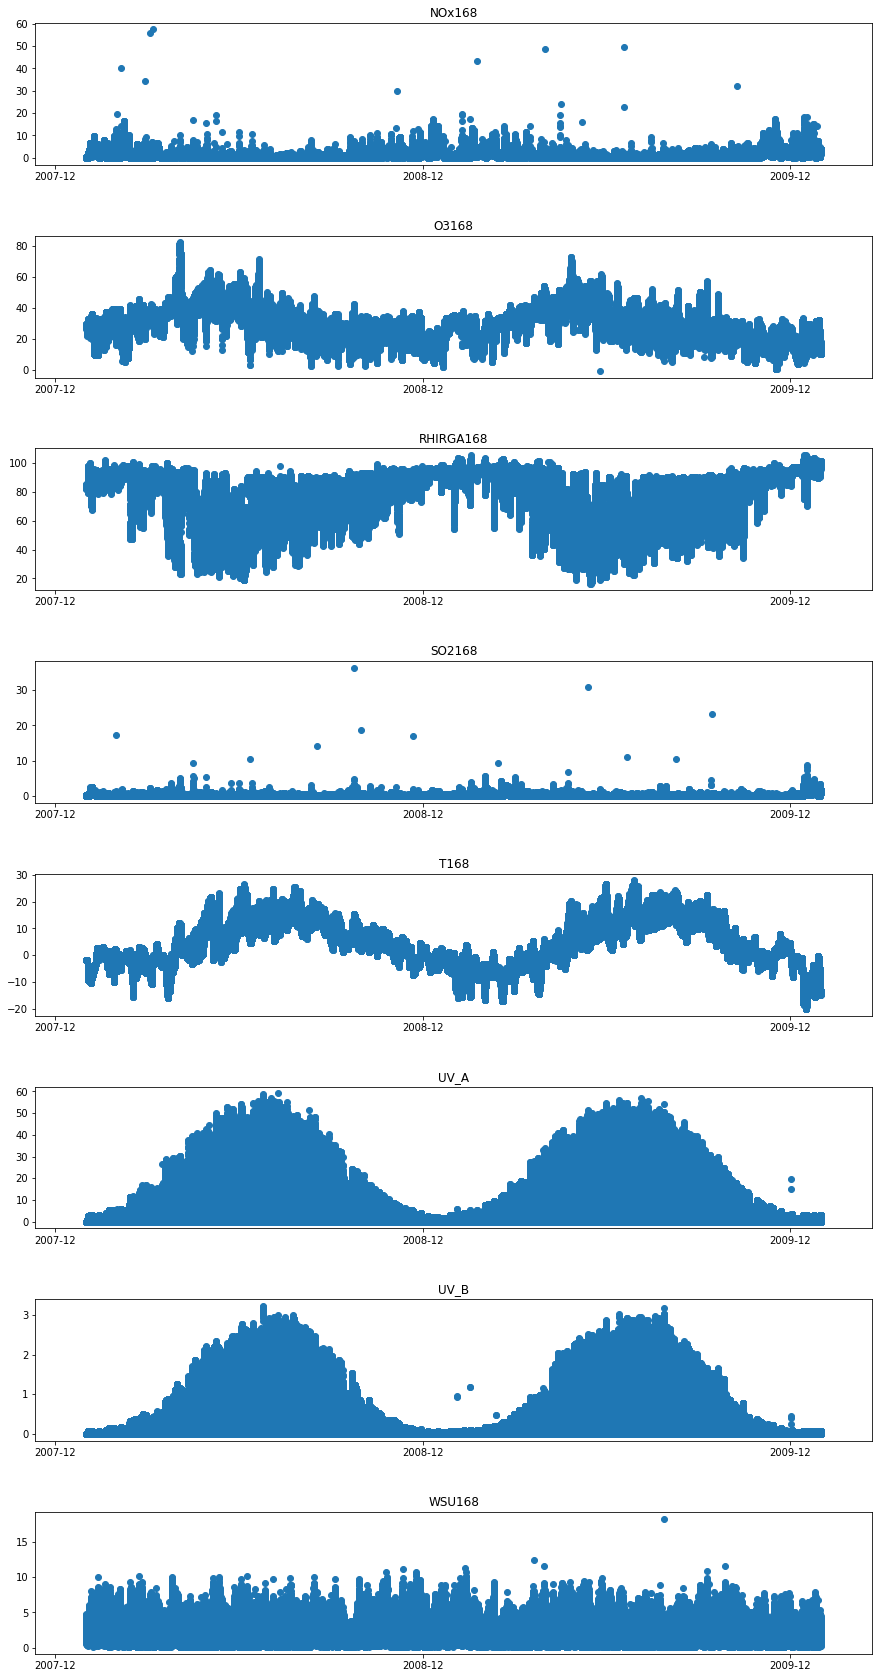

In [21]:
fig, axe = plt.subplots(df_raw.shape[1] - 1,1, figsize = (15, 30))
axe = axe.flatten()
for i in range(1, df_raw.shape[1]):
    axe[i-1].scatter(df_raw.Time, df_raw.iloc[:,i])
    axe[i-1].set_title(df_raw.columns[i])
    axe[i-1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

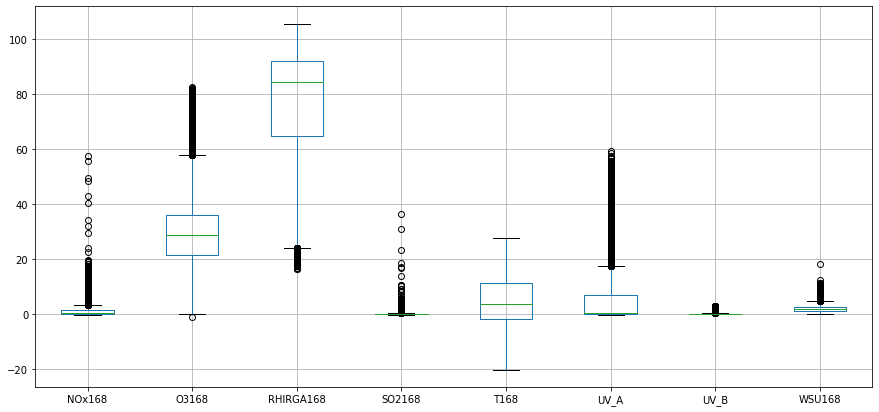

In [22]:
df_raw.boxplot(figsize = (15, 7))

<div class="alert alert-block alert-info">
    
Detecting outlier using boxplot for the raw time-series of two years is controversal because:
    
- Time-series are usually not stationary
    
- If the values only peak during a short time of every year (for example during the last week of every winter), then only a small set of data have such a high values (because there are 53 weeks in a year). As a result, the boxplot will consider those as outlier.
    
Instead, detecting outlier based on the distribution of the differences between two consecutive observations is a better idea. We wil make a function to remove outlier by first compute the distribution of diffences between two consecutive values. Then those differences that have $ \left | Z-score  \right |$ larger than 9 will be considered as outlier. In simple words, the increase between consecutive values will be removed (put as NaN) if they are too large in their distribution.

In [23]:
# Remove outlier based on quantile
#def remove_outlier_quantile(dataframe, quantile = 0.95, timecolumn = 'Time'):
#    data = dataframe.copy(deep = True)
#    for col in data:
#        if col not in [timecolumn]:
#            column_nona = data.loc[~data[col].isna(), col]
#            delta = column_nona - column_nona.shift(1)
#            q = delta.quantile(quantile)
#            idx = delta[delta > q].index
#            data.loc[idx, col] = np.NaN
#    return data

In [24]:
# Remove outlier based on zscore
def remove_outlier(dataframe, zscore = 1.96, timecolumn = 'Time'):
    from scipy import stats
    data = dataframe.copy(deep = True)
    for col in data:
        if col not in [timecolumn]:
            column_nona = data.loc[~data[col].isna(), col]
            delta = column_nona - column_nona.shift(1)
            delta.iloc[0] = np.nanmean(delta) # To include first value of the time series
            abs_zscore = np.abs(stats.zscore(delta))
            idx = delta[abs_zscore > zscore].index
            data.loc[idx, col] = np.NaN
    return data

# Remove outliers

In [25]:
df_processed = remove_outlier(df_raw, zscore = 2)

condense_processed = remove_outlier(condense_raw)

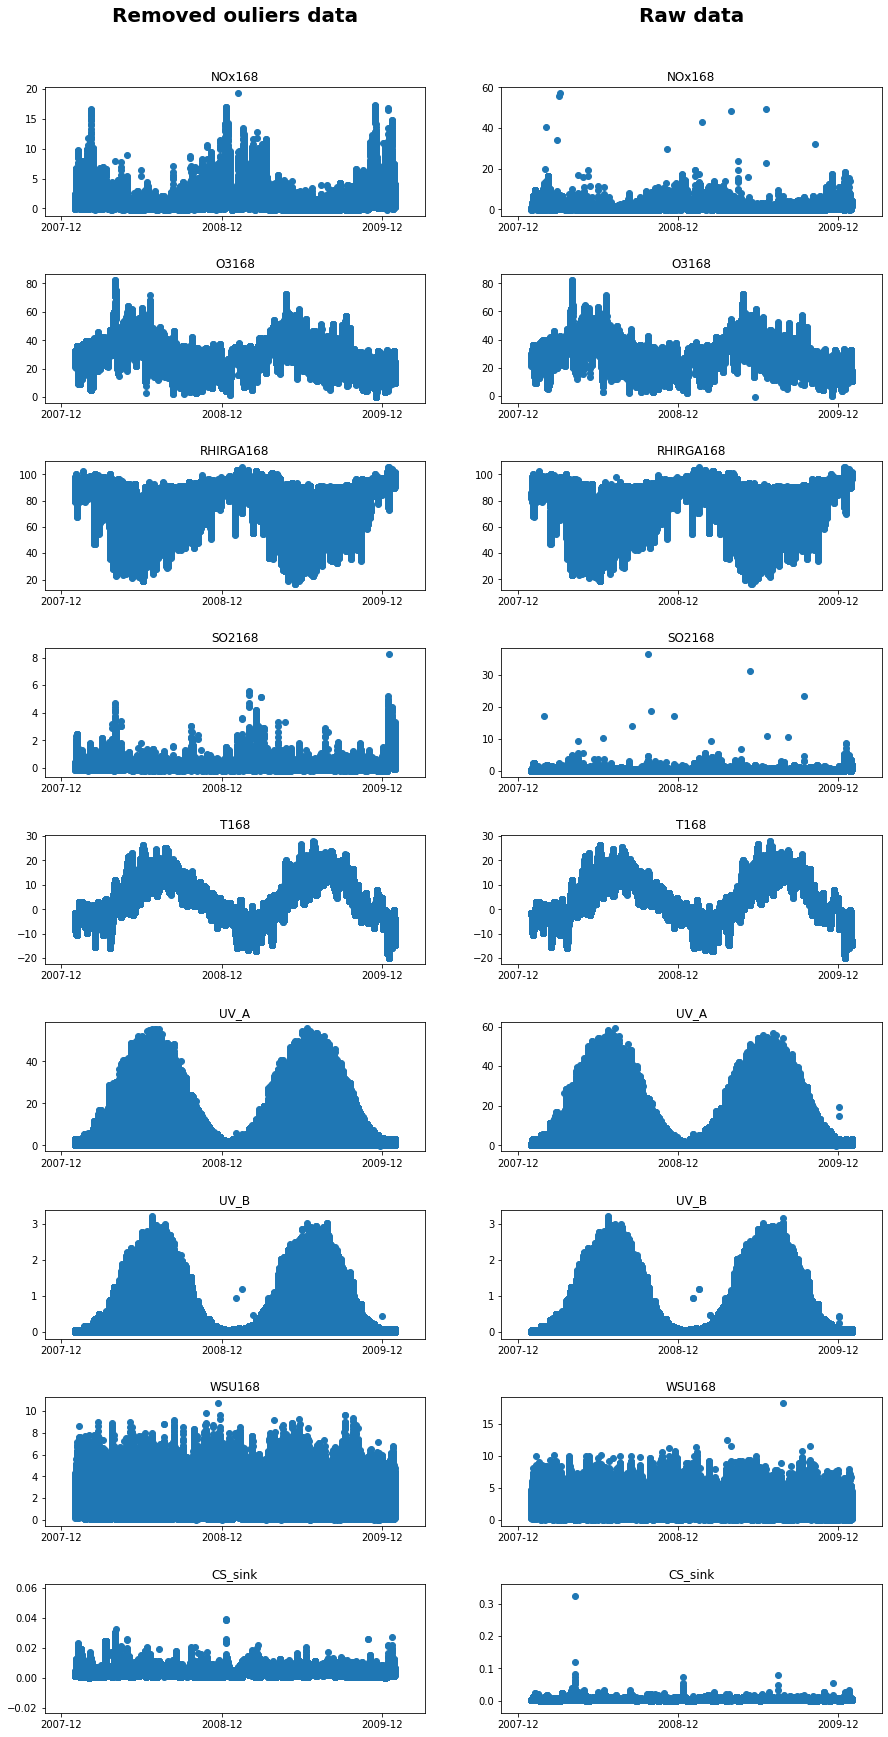

In [26]:
fig, axe = plt.subplots(df_raw.shape[1] + 1,2, figsize = (15, 30), gridspec_kw={"height_ratios":np.append(0.005, np.repeat(1,df_raw.shape[1]))})

axe[0,0].axis('off')
axe[0,0].set_title('Removed ouliers data', fontweight='bold', fontsize = 20)
axe[0,1].axis('off')
axe[0,1].set_title('Raw data', fontweight='bold', fontsize = 20)

for i in range(1, df_raw.shape[1]):
    axe[i, 0].scatter(df_processed.Time, df_processed.iloc[:,i])
    axe[i, 0].set_title(df_processed.columns[i])
    axe[i, 0].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    axe[i, 1].scatter(df_raw.Time, df_raw.iloc[:,i])
    axe[i, 1].set_title(df_raw.columns[i])
    axe[i, 1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))    

axe[df_raw.shape[1] , 0].scatter(condense_processed.Time, condense_processed.CS_sink)
axe[df_raw.shape[1] , 0].set_title('CS_sink')
axe[df_raw.shape[1] , 0].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
axe[df_raw.shape[1] , 1].scatter(condense_raw.Time, condense_raw.CS_sink)
axe[df_raw.shape[1] , 1].set_title('CS_sink')
axe[df_raw.shape[1] , 1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None)) 

fig.subplots_adjust(left=None, bottom=0.1, right=None, top=None, wspace=None, hspace=0.5)

# Aggregate data

#### Calculate hourly data

In [27]:
event = event.set_index('Time')
condense_hourly = condense_processed.groupby([condense_processed["Time"].dt.date,condense_processed["Time"].dt.hour]).mean()
df_hourly = df_processed.groupby([df_processed["Time"].dt.date,df_processed["Time"].dt.hour]).mean()
combined_hourly = condense_hourly.join(df_hourly)
combined_hourly.index.rename(['Time', 'Hour'], inplace = True)
combined_hourly =event.join(combined_hourly)

#### Calculate daily data

In [28]:
condense_daily = condense_processed.groupby([condense_processed["Time"].dt.date]).mean()
df_daily = df_processed.groupby([df_processed["Time"].dt.date]).mean()

combined_daily = event.join(condense_daily).join(df_daily)

# Add proxy 

$[H_2SO_4]_{proxy} = k \cdot \frac{[SO_2][UVB]}{CS}$

In [29]:
combined_daily['proxy'] = combined_daily['SO2168'] * combined_daily['UV_B'] * 9.9e-7 / combined_daily['CS_sink'] * 2.62e-6 / 64 * 6.023e23 / 1e6
combined_hourly['proxy'] = combined_hourly['SO2168'] * combined_hourly['UV_B'] * 9.9e-7 / combined_hourly['CS_sink'] * 2.62e-6 / 64 * 6.023e23 / 1e6

# Analysis

# Event frequency

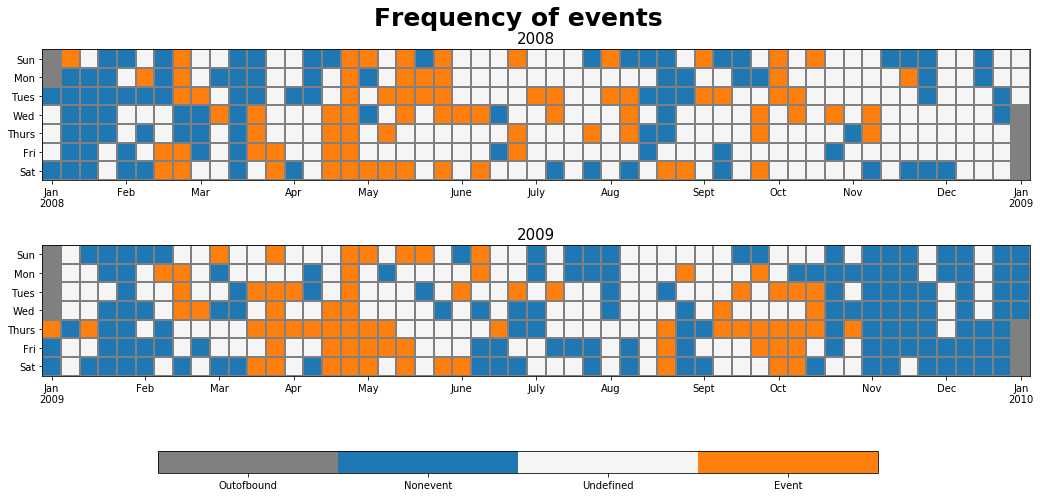

In [30]:
from matplotlib import colors
# Make dataframe for the calendar plot
value_to_int = {j:i+1 for i,j in enumerate(pd.unique(event.values.ravel()))}
event_cal = event.replace(value_to_int)
cal = {'2008': event_cal[event_cal.index.year == 2008], '2009': event_cal[event_cal.index.year == 2009]}
# Define Ticks
DAYS = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(2, 1, figsize = (20,6))
for i, val in enumerate(['2008', '2009']):
    start = cal.get(val).index.min()
    end = cal.get(val).index.max()
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun =  end + np.timedelta64(7 - end.dayofweek -1, 'D')

    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {} 
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = cal.get(val).loc[date, 'Event_category']

    cmap = colors.ListedColormap(['gray', 'tab:blue', 'whitesmoke', 'tab:orange'])
    mesh = ax[i].pcolormesh(x, y, heatmap, cmap = cmap, edgecolors = 'grey')

    ax[i].invert_yaxis()

    # Set the ticks.
    ax[i].set_xticks(list(ticks.keys()))
    ax[i].set_xticklabels(list(ticks.values()))
    ax[i].set_yticks(np.arange(7))
    ax[i].set_yticklabels(DAYS)
    ax[i].set_ylim(6.5,-0.5)
    ax[i].set_aspect('equal')
    ax[i].set_title(val, fontsize = 15)

cbar_ax = fig.add_axes([0.25, -0.10, 0.5, 0.05])
fig.colorbar(mesh, orientation="horizontal", pad=0.2, cax = cbar_ax)
n = len(value_to_int) +1
colorbar = ax[1].collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(['Outofbound'] + list(value_to_int.keys()))    
fig.suptitle('Frequency of events', fontweight = 'bold', fontsize = 25)
fig.subplots_adjust(hspace = 0.5)

# Correlation plot
Choose color color bar first

In [31]:
cmap = sns.choose_diverging_palette(as_cmap = True)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

Change the color bar above then run the code below again to apply new color bar (Don't run the code above again)

Text(0.5, 1, 'Hourly correlation')

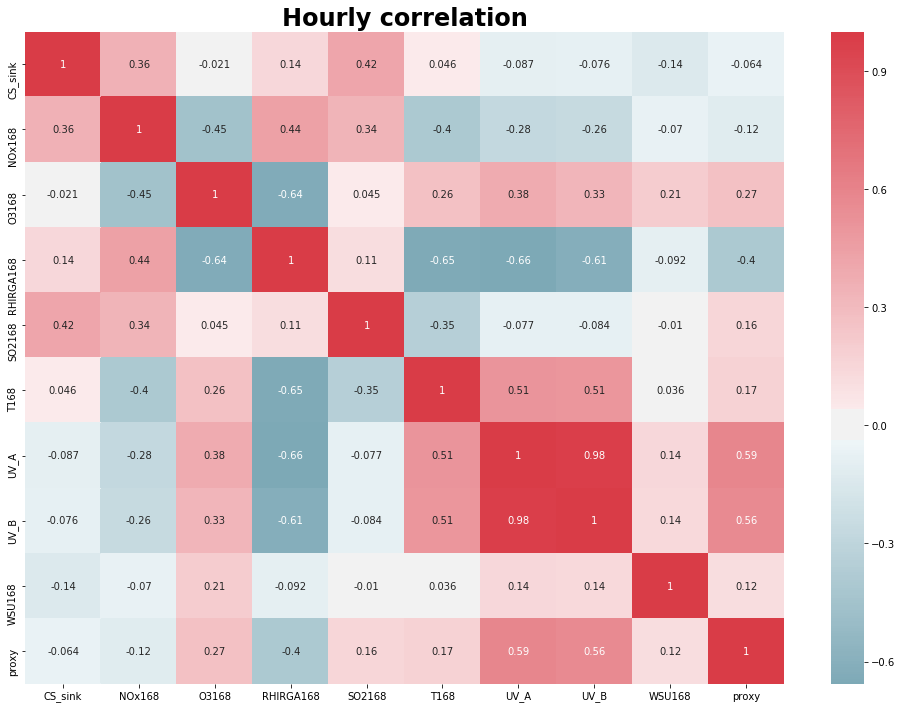

In [32]:
fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(combined_hourly.corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(combined_hourly.shape[1]-1,0)
ax.set_title('Hourly correlation', weight = "bold", fontsize=24)

Text(0.5, 1, 'Daily correlation on Non-Event day')

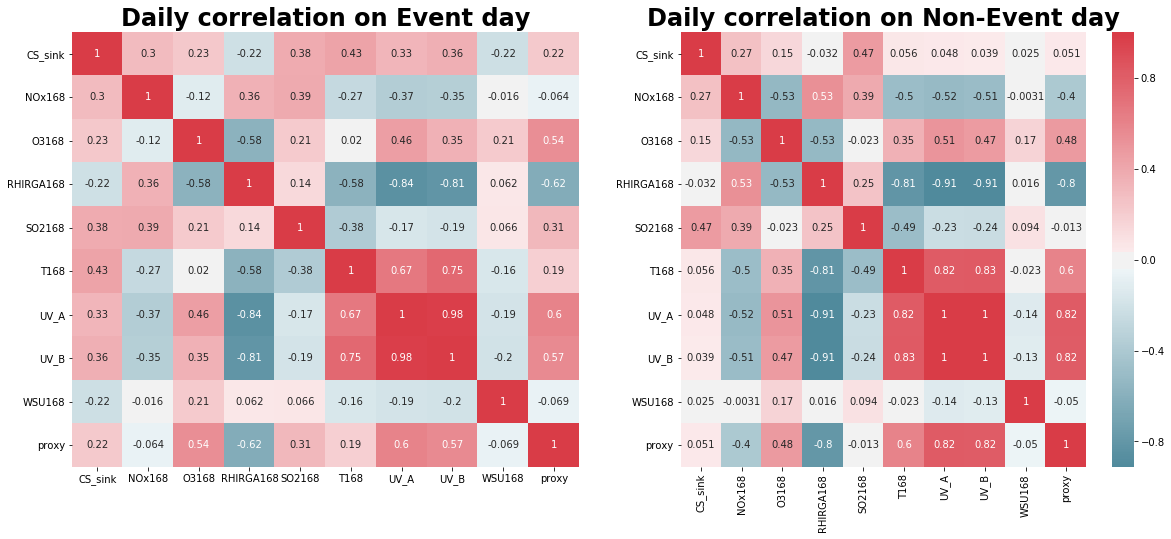

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
sns.heatmap(combined_daily[combined_daily.Event_category == 'Event'].corr(), cmap = cmap, center=0.00, ax = ax[0], annot = True, cbar = False)
ax[0].set_ylim(combined_daily.shape[1]-1,0)
ax[0].set_title('Daily correlation on Event day', weight = "bold", fontsize=24)
sns.heatmap(combined_daily[combined_daily.Event_category == 'Nonevent'].corr(), cmap = cmap, center=0.00, ax = ax[1], annot = True, cbar = True)
ax[1].set_ylim(combined_daily.shape[1]-1,0)
ax[1].set_title('Daily correlation on Non-Event day', weight = "bold", fontsize=24)

# Cross-correlation

Text(0.5, 1, 'Value of each cell is time lag (hour)')

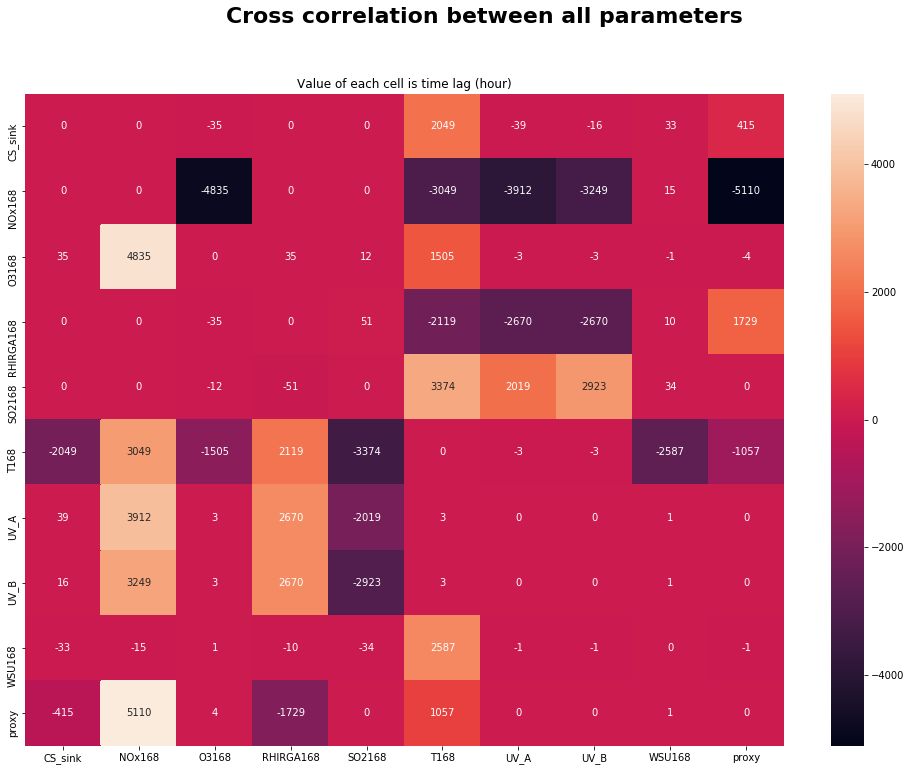

In [53]:
cross_correlation = np.zeros((combined_hourly.shape[1] - 1, combined_hourly.shape[1] - 1))
for ii, i in enumerate(combined_hourly.columns[1:]):
    for jj, j in enumerate(combined_hourly.columns[1:]):
        if j != i:
            pair = combined_hourly[[i, j]].dropna(axis = 0) 
            c = np.correlate(pair[i], pair[j], mode = 'full')
            icmax = np.argmax(c)
            tlag = -1 * (icmax - len(pair[i]) +1)
            cross_correlation[ii,jj] = tlag

fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(cross_correlation.astype(int), xticklabels = combined_hourly.columns[1:], yticklabels = combined_hourly.columns[1:], ax = ax, annot = True, fmt="d")
ax.set_ylim(combined_hourly.shape[1] -1 ,0)
fig.suptitle('Cross correlation between all parameters', fontweight = 'bold', size = 22)
ax.set_title('Value of each cell is time lag (hour)')

# Time-series plot

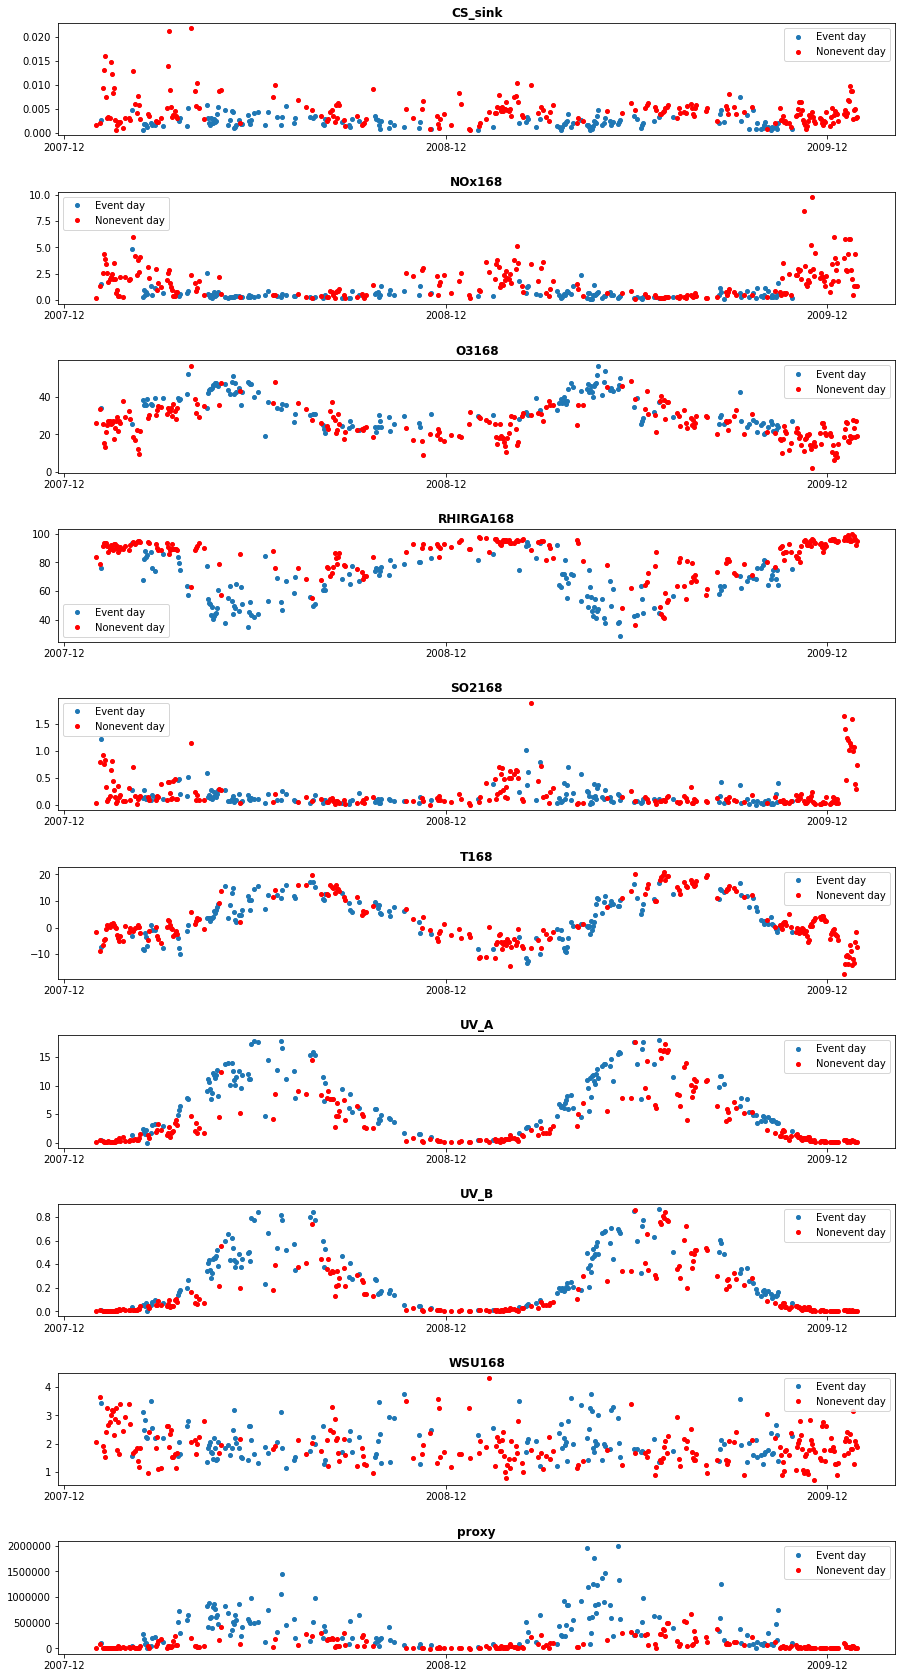

In [52]:
fig, axe = plt.subplots(combined_daily.shape[1]-1, figsize = (15, 30))
for i in range(combined_daily.shape[1]-1):
    axe[i].plot(combined_daily[combined_daily.Event_category == 'Event'].iloc[:,i+1],'.', markersize = 8 ,label = 'Event day')
    axe[i].plot(combined_daily[combined_daily.Event_category == 'Nonevent'].iloc[:,i+1], '.' , markersize = 8,c = 'red', label = 'Nonevent day')
#    axe[i].plot(combined_daily[combined_daily.Event_category == 'Undefined'].iloc[:,i+1], c = 'green', marker = '.', label = 'Undefined day')
    axe[i].set_title(combined_daily.columns[i+1], fontweight = 'bold')
    axe[i].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    axe[i].legend()
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Seasonal pattern based on Event

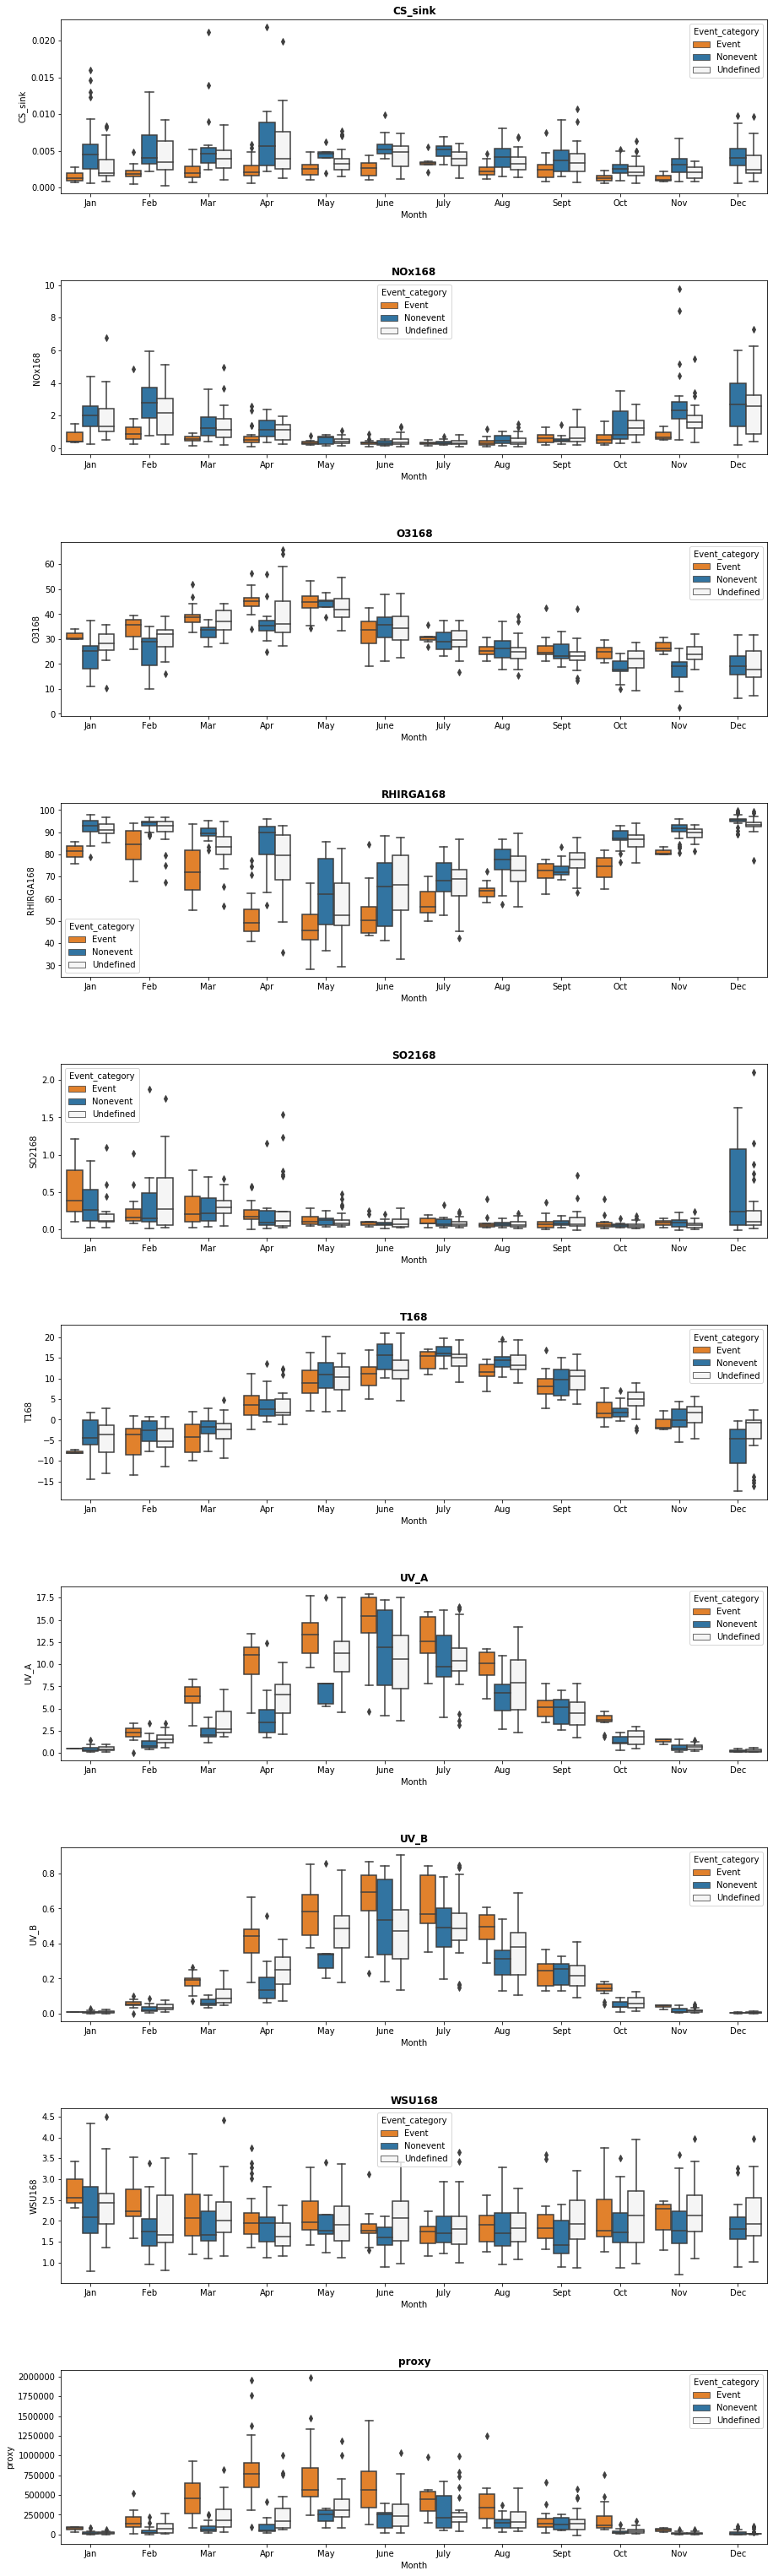

In [36]:
fig, ax = plt.subplots(combined_daily.shape[1] - 1, figsize = (15, 55))
for i in range(combined_daily.shape[1] - 1):
    sns.boxplot(x = combined_daily.index.month, y = combined_daily.iloc[:,i+1], hue = combined_daily['Event_category'], palette = {'Nonevent' : 'tab:blue', 'Undefined' : 'whitesmoke', 'Event' : 'tab:orange'}, hue_order = ['Event', 'Nonevent', 'Undefined'], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i+1], fontweight = 'bold')
    ax[i].set_xlabel('Month')
    ax[i].set_xticklabels(MONTHS)
     
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Diurnal pattern based on Event

#### WINTER

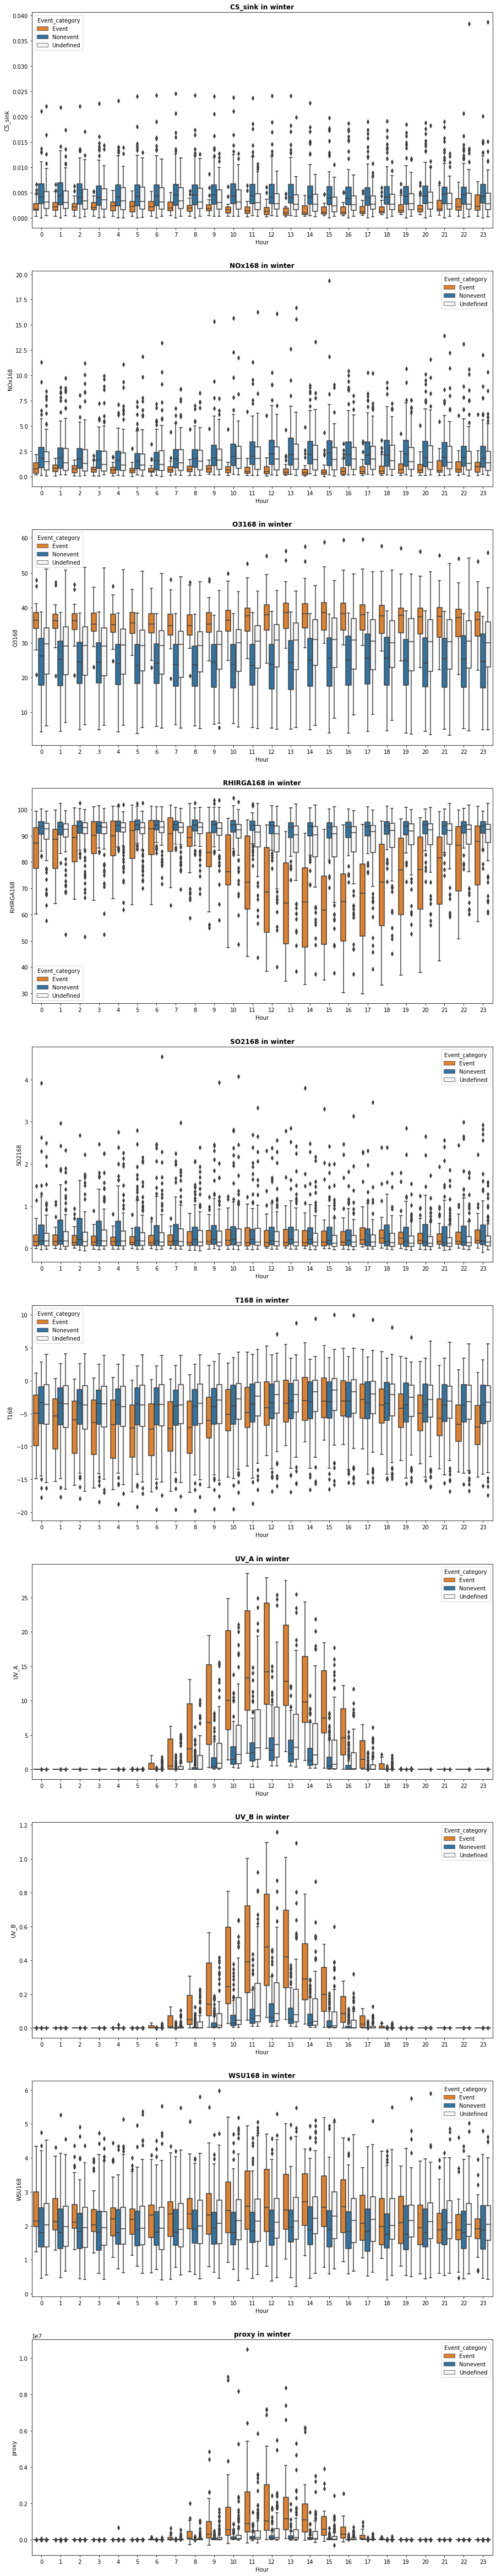

In [37]:
winter = [12,1,2,3]
idx = np.in1d(combined_hourly.index.get_level_values('Time').month, winter)
fig, ax = plt.subplots(combined_hourly.shape[1] - 1, figsize = (15, 85))
for i in range(combined_hourly.shape[1] - 1):
    sns.boxplot(x = combined_hourly[idx].index.get_level_values('Hour'), y = combined_hourly[idx].iloc[:,i+1], hue = combined_hourly.loc[idx,'Event_category'], palette = {'Nonevent' : 'tab:blue', 'Undefined' : 'whitesmoke', 'Event' : 'tab:orange'}, hue_order = ['Event', 'Nonevent', 'Undefined'], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i+1] + ' in winter', fontweight = 'bold')
    ax[i].set_xlabel('Hour')    

#### SPRING

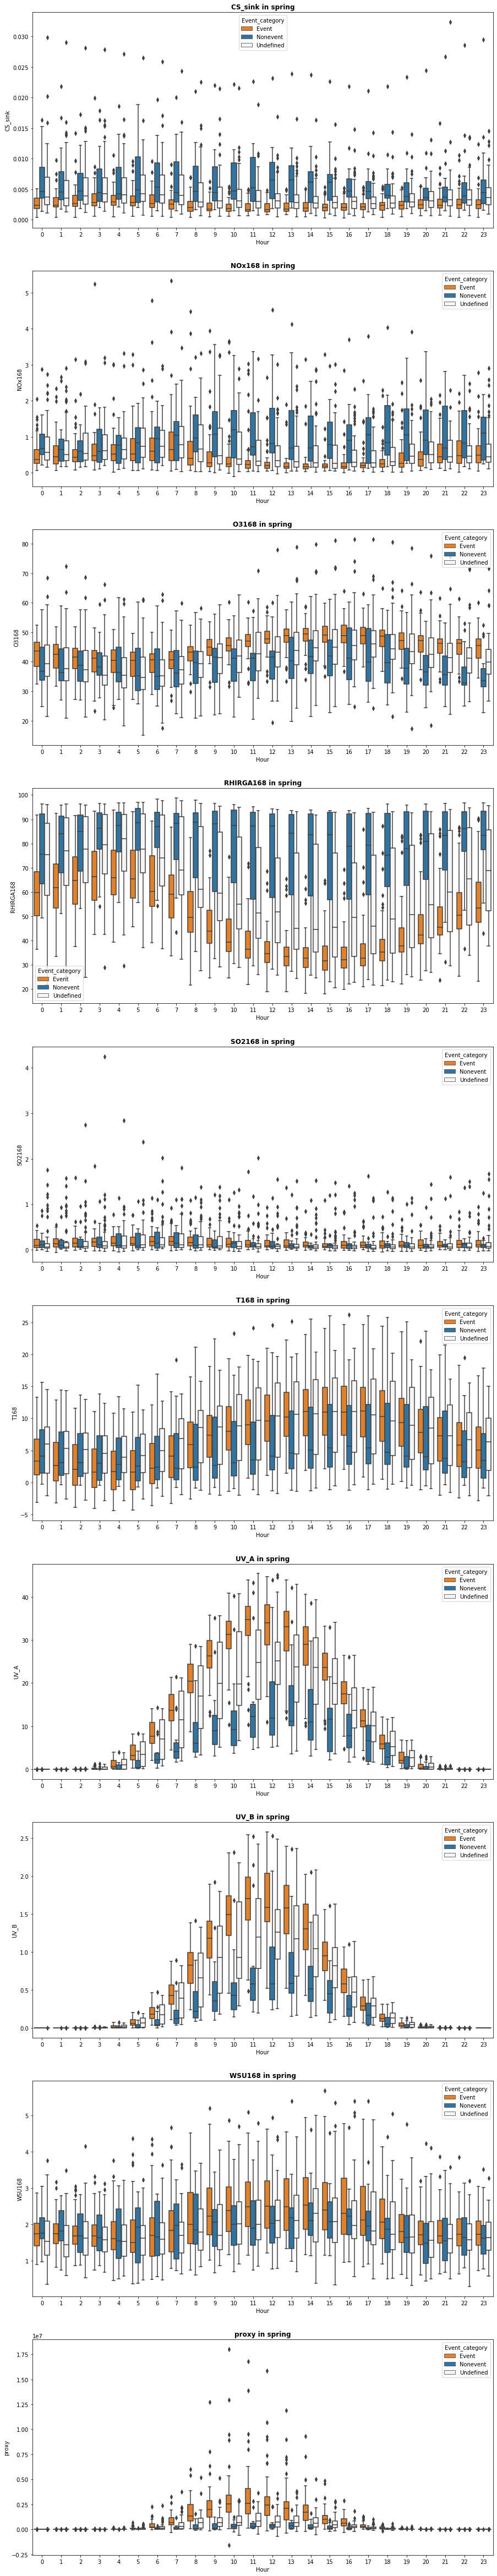

In [38]:
spring = [4, 5]
idx = np.in1d(combined_hourly.index.get_level_values('Time').month, spring)
fig, ax = plt.subplots(combined_hourly.shape[1] - 1, figsize = (15, 85))
for i in range(combined_hourly.shape[1] - 1):
    sns.boxplot(x = combined_hourly[idx].index.get_level_values('Hour'), y = combined_hourly[idx].iloc[:,i+1], hue = combined_hourly.loc[idx,'Event_category'], palette = {'Nonevent' : 'tab:blue', 'Undefined' : 'whitesmoke', 'Event' : 'tab:orange'}, hue_order = ['Event', 'Nonevent', 'Undefined'], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i+1] + ' in spring', fontweight = 'bold')
    ax[i].set_xlabel('Hour')    

#### SUMMER

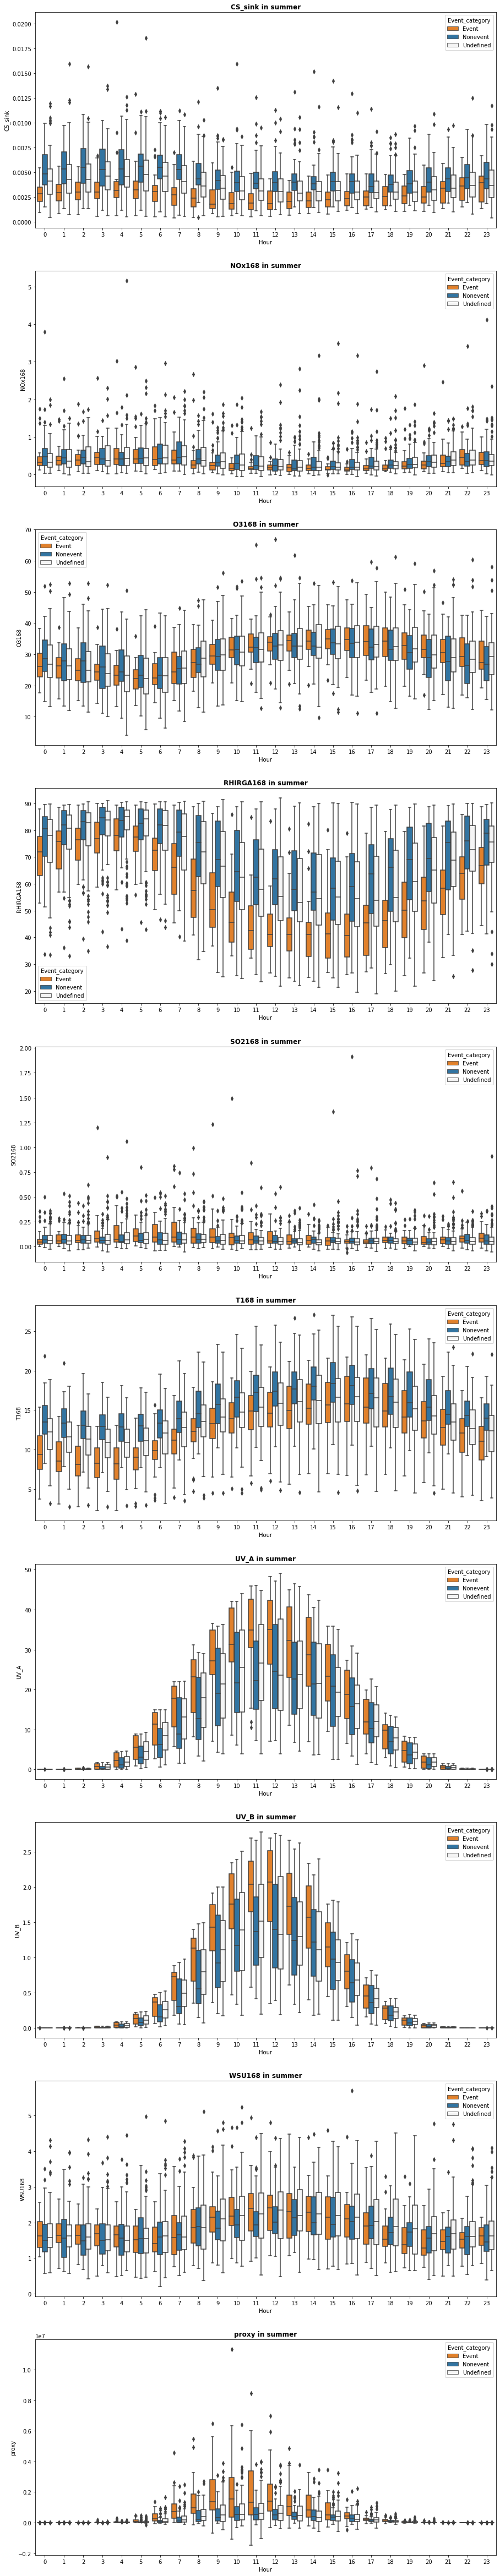

In [39]:
summer = [6,7,8]
idx = np.in1d(combined_hourly.index.get_level_values('Time').month, summer)
fig, ax = plt.subplots(combined_hourly.shape[1] - 1, figsize = (15, 85))
for i in range(combined_hourly.shape[1] - 1):
    sns.boxplot(x = combined_hourly[idx].index.get_level_values('Hour'), y = combined_hourly[idx].iloc[:,i+1], hue = combined_hourly.loc[idx,'Event_category'], palette = {'Nonevent' : 'tab:blue', 'Undefined' : 'whitesmoke', 'Event' : 'tab:orange'}, hue_order = ['Event', 'Nonevent', 'Undefined'], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i+1] + ' in summer', fontweight = 'bold')
    ax[i].set_xlabel('Hour')    

#### AUTUMN

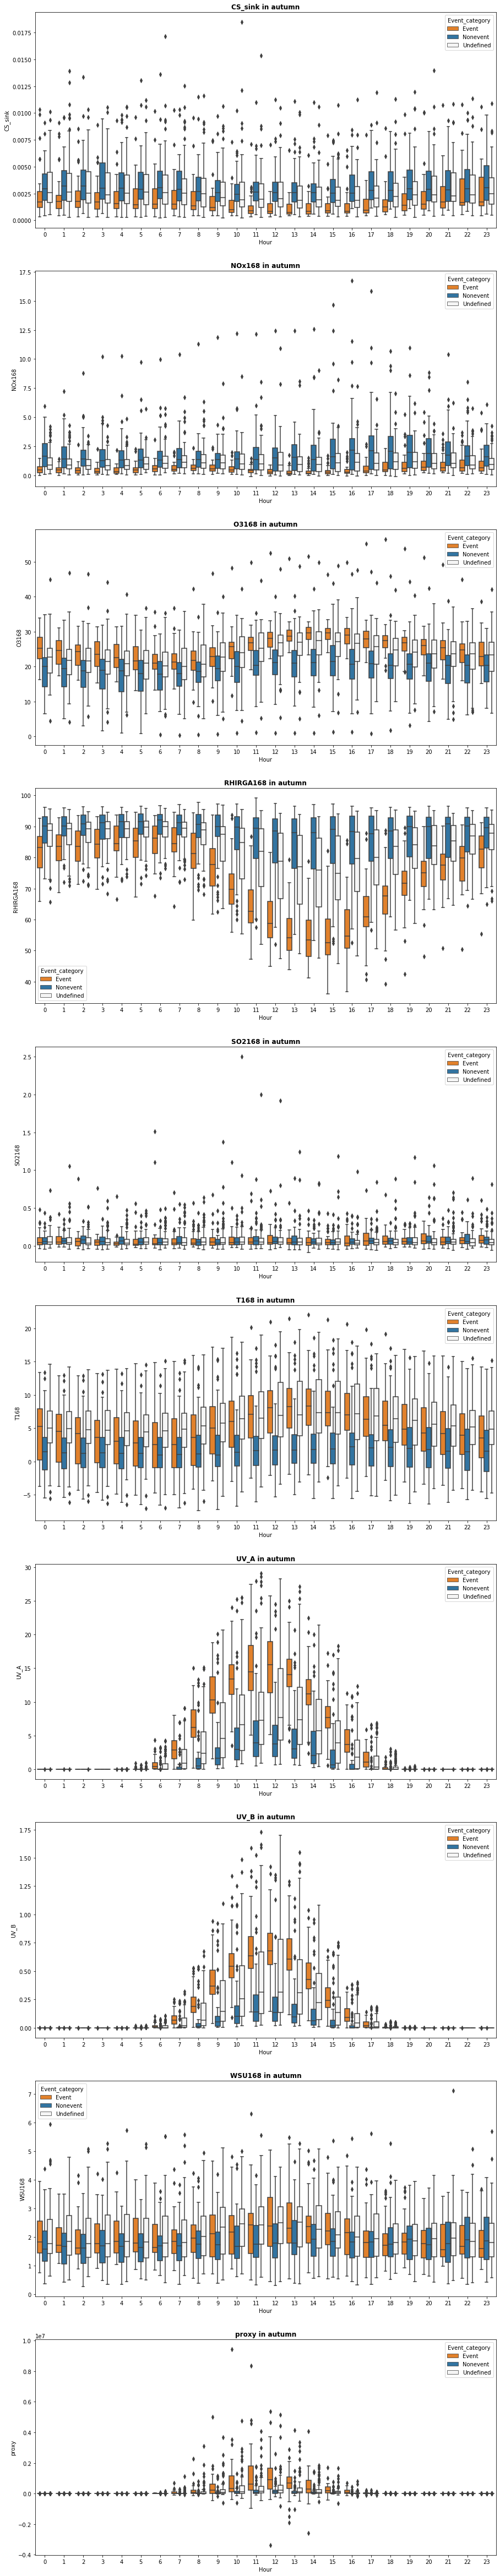

In [40]:
autumn = [9,10,11]
idx = np.in1d(combined_hourly.index.get_level_values('Time').month, autumn)
fig, ax = plt.subplots(combined_hourly.shape[1] - 1, figsize = (15, 85))
for i in range(combined_hourly.shape[1] - 1):
    sns.boxplot(x = combined_hourly[idx].index.get_level_values('Hour'), y = combined_hourly[idx].iloc[:,i+1], hue = combined_hourly.loc[idx,'Event_category'], palette = {'Nonevent' : 'tab:blue', 'Undefined' : 'whitesmoke', 'Event' : 'tab:orange'}, hue_order = ['Event', 'Nonevent', 'Undefined'], ax = ax[i])
    ax[i].set_title(combined_daily.columns[i+1] + ' in autumn', fontweight = 'bold')
    ax[i].set_xlabel('Hour')    

# Check normality assumptions of all parameters for each Event category

C:\Users\LV\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\LV\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'Check normality of all parameters for Nonevent')

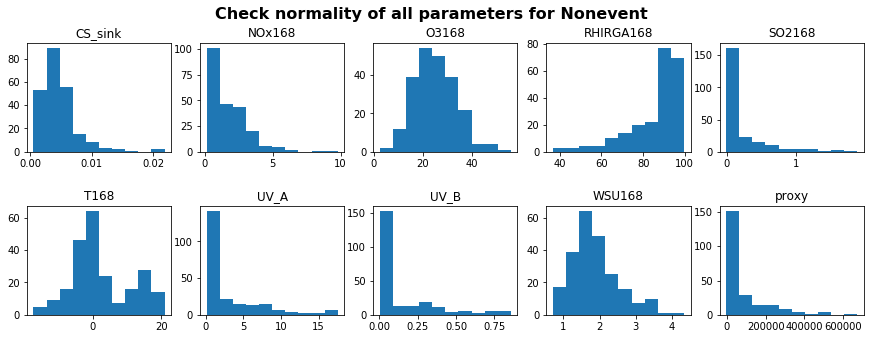

In [41]:
fig, ax = plt.subplots(2,5, figsize = (15,5))
ax = ax.flatten()
for i, ax in enumerate(ax):
    ax.hist(combined_daily[combined_daily['Event_category'] == 'Nonevent'].iloc[:,i+1])
    ax.set_title(combined_daily.columns[i+1])
    
fig.subplots_adjust(hspace = 0.5)
fig.suptitle('Check normality of all parameters for Nonevent', fontweight = 'bold', size = 16)

Text(0.5, 0.98, 'Check normality of all parameters for Event')

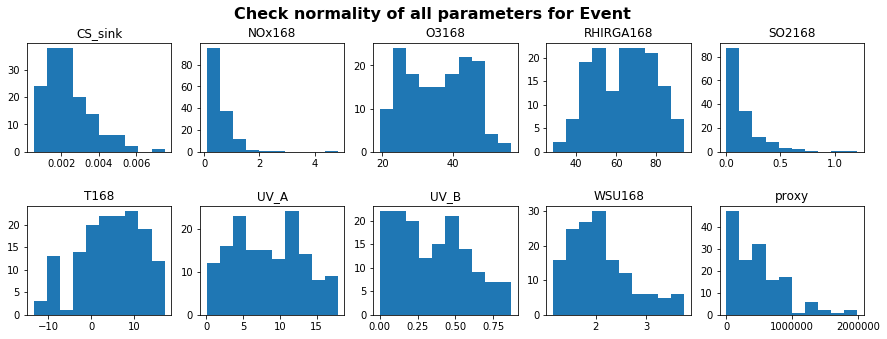

In [42]:
fig, ax = plt.subplots(2,5, figsize = (15,5))
ax = ax.flatten()
for i, ax in enumerate(ax):
    ax.hist(combined_daily[combined_daily['Event_category'] == 'Event'].iloc[:,i+1])
    ax.set_title(combined_daily.columns[i+1])
    
fig.subplots_adjust(hspace = 0.5)
fig.suptitle('Check normality of all parameters for Event', fontweight = 'bold', size = 16)

<div class="alert alert-block alert-info"> They are not normally distributed, need to use Non-parametric tests

# Kruskal-Wallis test

Test if values for each parameters are significant different from each Event category (Nonevent, Event and Undefined)

In [54]:
from scipy.stats import kruskal
Event = combined_daily[combined_daily.Event_category == 'Event']
Nonevent = combined_daily[combined_daily.Event_category == 'Nonevent']
Undefined = combined_daily[combined_daily.Event_category == 'Undefined']
for i, col in enumerate(combined_daily.columns[1:]):
    stat, p = kruskal(Event[col].dropna(axis = 0).values, Nonevent[col].dropna(axis = 0).values, Undefined[col].dropna(axis = 0).values)
    print(col)
    print(f'Statistics :{stat}, p value = {p}')
    if p < 0.05:
        print("Reject NULL hypothesis - Significant differences exist between groups.")
    if p > 0.05:
        print("Accept NULL hypothesis - No significant difference between groups.")
    print('-' * 100 + '\n')

CS_sink
Statistics :100.17401361194061, p value = 1.7680287756421552e-22
Reject NULL hypothesis - Significant differences exist between groups.
----------------------------------------------------------------------------------------------------

NOx168
Statistics :83.01048790252935, p value = 9.42978046250701e-19
Reject NULL hypothesis - Significant differences exist between groups.
----------------------------------------------------------------------------------------------------

O3168
Statistics :99.66661303313367, p value = 2.2786098208334064e-22
Reject NULL hypothesis - Significant differences exist between groups.
----------------------------------------------------------------------------------------------------

RHIRGA168
Statistics :174.67099760304018, p value = 1.176724501227011e-38
Reject NULL hypothesis - Significant differences exist between groups.
----------------------------------------------------------------------------------------------------

SO2168
Statistics :12.

#### Event on 2009 vs 2008 in late spring and early summer

In [70]:
period = [4,5,6]

period_data = combined_daily[np.in1d(combined_daily.index.month,period)]
y2008 = period_data[period_data.index.year == 2008]
y2009 = period_data[period_data.index.year == 2009]
y2008_event = y2008[y2008.Event_category == 'Event']
y2009_event = y2009[y2009.Event_category == 'Event']


for i, col in enumerate(combined_daily.columns[1:]):
    stat, p = kruskal(y2008_event[col].dropna(axis = 0).values, y2009_event[col].dropna(axis = 0).values)
    print(col)
    print(f'Statistics :{stat}, p value = {p}')
    if p < 0.05:
        print("Reject NULL hypothesis - Significant differences exist between groups.")
    if p > 0.05:
        print("Accept NULL hypothesis - No significant difference between groups.")
    print('-' * 100 + '\n')

CS_sink
Statistics :5.354570135746627, p value = 0.020668028699104363
Reject NULL hypothesis - Significant differences exist between groups.
----------------------------------------------------------------------------------------------------

NOx168
Statistics :0.18533936651584781, p value = 0.6668242662625109
Accept NULL hypothesis - No significant difference between groups.
----------------------------------------------------------------------------------------------------

O3168
Statistics :0.004524886877845802, p value = 0.946368925124135
Accept NULL hypothesis - No significant difference between groups.
----------------------------------------------------------------------------------------------------

RHIRGA168
Statistics :0.06533936651584327, p value = 0.79824762378497
Accept NULL hypothesis - No significant difference between groups.
----------------------------------------------------------------------------------------------------

SO2168
Statistics :0.06533936651584327, p v

<div class="alert alert-block alert-info">Significant differences found in all parameters except CS_sink between 2008 and 2009 events during April, May and June

#### Boxplot comparing value of CS_sink in event days in 2008 and 2009

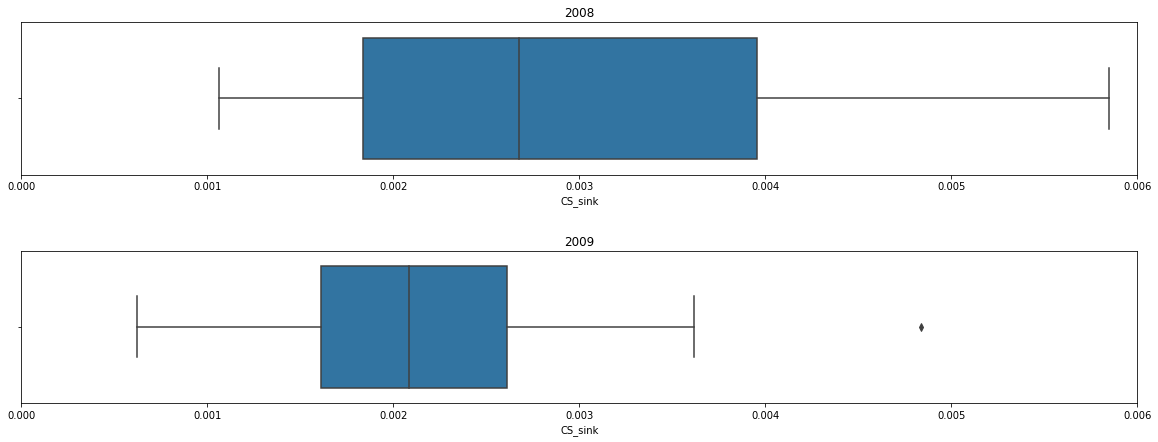

In [89]:
fig, ax = plt.subplots(2,1, figsize = (20,7))
sns.boxplot(y2008_event['CS_sink'], ax = ax[0])
ax[0].set_title('2008')
ax[0].set_xlim(0,0.006)
sns.boxplot(y2009_event['CS_sink'], ax = ax[1])
ax[1].set_title('2009')
ax[1].set_xlim(0,0.006)

fig.subplots_adjust(hspace = 0.5)

# PCA

In [44]:
# Standardize data
from sklearn.preprocessing import StandardScaler
x = combined_daily.dropna(axis = 0).drop('Event_category', axis = 1).values
y = combined_daily.dropna(axis = 0)['Event_category'].values
x = StandardScaler().fit_transform(x)

# PCA
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca_result = pca.fit_transform(x)
print(f'Number of components: {pca.explained_variance_ratio_.shape[0]}')
print(f'Explained variance of each components: {pca.explained_variance_ratio_}')

Number of components: 6
Explained variance of each components: [0.47761098 0.17301304 0.12324446 0.08700038 0.0577256  0.03373344]


#### Plot cummulative sum variance explained by each components

Text(0, 0.5, 'Explained variance')

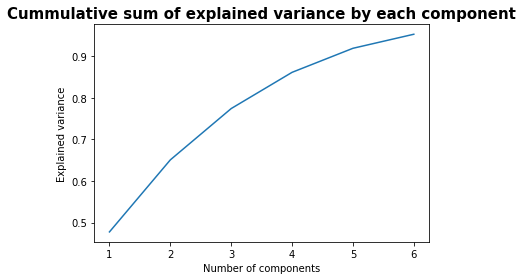

In [45]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks([0, 1,2,3,4,5])
# ax.set_xlim(0,6)
ax.set_xticklabels(list(np.arange(1,7)))
ax.set_title('Cummulative sum of explained variance by each component', fontweight = 'bold', size = 15)
ax.set_xlabel('Number of components')
ax.set_ylabel('Explained variance')

## Plot data on first two components

Explained variance of each components[0.47761098 0.17301304]


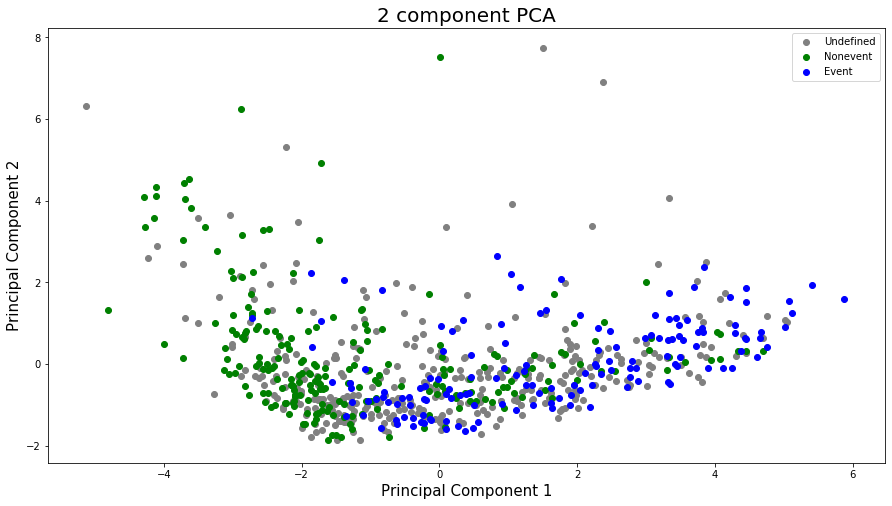

In [46]:
# Plot on first two components
fig, ax = plt.subplots(1,1,figsize = (15,8))
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
color = {'Event': 'blue', 'Nonevent' : 'green', 'Undefined' : 'grey'}

for i in ['Undefined', 'Nonevent', 'Event']:
    mask = y == i
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=i, c = color.get(i), alpha = 1)
ax.legend()
print(f'Explained variance of each components{pca.explained_variance_ratio_[:2]}')

<div class="alert alert-block alert-info"> With just two components, PCA is able to separate Event and Nonevent

# K-nearest neighbor

Text(0.5, 0.98, 'Confusion matrix for K-nearest neighbor algorithm')

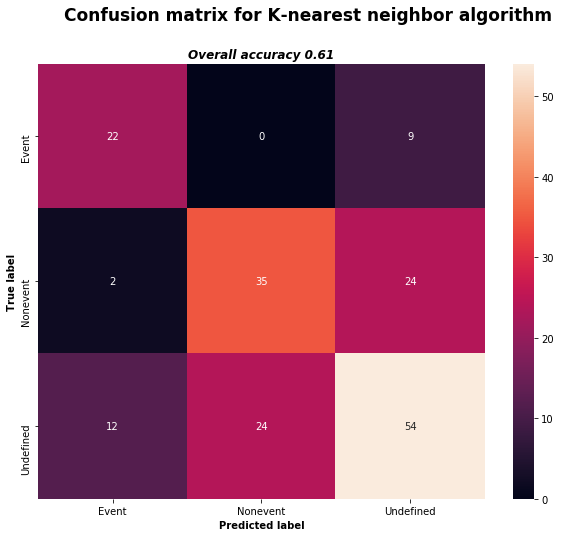

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Split to train and test set 
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

# K-nearest neighbor
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Generate confusion matrix to evaluate on test set
classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, xticklabels = classes, yticklabels = classes,
            annot = True, fmt="d", ax = ax)
ax.set_ylim(3,0)
ax.set_ylabel('True label', size = 10, fontweight = 'bold')
ax.set_xlabel('Predicted label', size = 10, fontweight = 'bold')
ax.set_title(f'Overall accuracy {accuracy_score(y_test, y_pred):.2}', fontweight = 'bold', fontstyle = 'italic')

fig.suptitle('Confusion matrix for K-nearest neighbor algorithm', size = 17, fontweight = 'bold')

<div class="alert alert-block alert-info"> Even though overall accuracy is only 0.61, the algorithm is doing extremely well at not mixing up prediction between Event and Nonevent.

#### K-fold cross validation

In [48]:
# Import KFold class from scikitlearn library
from sklearn.model_selection import KFold

K=5    # number of folds/rounds/splits
kf = KFold(n_splits=K, shuffle=False)
kf = kf.split(x)
kf = list(kf)                 # kf is a list representing the rounds of k-fold CV



train_acc_per_cv_iteration = []
test_acc_per_cv_iteration = []  

# for loop over K rounds 
        
for train_indices, test_indices in kf:
        
    reg = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    reg = reg.fit(x[train_indices,:], y[train_indices])
    y_pred_train = reg.predict(x[train_indices,:])
    train_acc_per_cv_iteration.append(accuracy_score(y[train_indices], y_pred_train))
    y_pred_val = reg.predict(x[test_indices,:])
    test_acc_per_cv_iteration.append(accuracy_score(y[test_indices], y_pred_val))
            

acc_train= np.mean(train_acc_per_cv_iteration) # compute the mean of round-wise training acc
acc_val = np.mean(test_acc_per_cv_iteration)   # compute the mean of round-wise validation acc
        
print("Training accuracy (averaged over 5 folds): ",acc_train)
print("Validation accuracy (averaged over 5 folds):", acc_val)


Training accuracy (averaged over 5 folds):  0.7324333788355393
Validation accuracy (averaged over 5 folds): 0.5247709022201228


<div class="alert alert-block alert-info"> The overall accuracy in smaller in cross-validation. It shows that in the first train and test split, we were lucky at getting indices to get the high accuracy in the test set